In [2]:
# Import libraries
from math import atan2, cos, sin, sqrt, pi
import numpy as np
import cv2 as cv
import os
import glob
import time
import pandas as pd
#from scipy.signal import butter, lfilter
#from scipy import signal
#from scipy.signal import find_peaks, resample_poly

# from joblib import Parallel, delayed
# import multiprocessing
# from ipywidgets import interactive, widgets
# from skimage.registration import phase_cross_correlation
# from skimage.registration._phase_cross_correlation import _upsampled_dft
# from scipy.ndimage import fourier_shift
from matplotlib.image import imread
import matplotlib.pyplot as plt 
from PIL import Image
# import PyCBD.pipelines
# from PyCBD.pipelines import CBDPipeline
# from PyCBD.checkerboard_detection.checkerboard_detector import CheckerboardDetector
import matplotlib.transforms as mtransforms


In [11]:
camera_1400k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_2100K.npz")
K1=camera_1400k['camera_matrix']
D1=camera_1400k['dist_coeffs']
camera_480k = np.load(r"D:\FST_972_FF_Sphere\Calibration\camera_calibration_480K.npz")
K2=camera_480k['camera_matrix']
D2=camera_480k['dist_coeffs']
camera_setup=np.load(r"D:\FST_972_FF_Sphere\Calibration\stereo_camera_calibration.npz")
R=camera_setup['rotation_mat']
T=camera_setup['transalation_vect']

# Image size (should be the same for both cameras)
image_size = (1024, 840)  # Replace with actual image dimensions

# Stereo rectification
R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(
    K1, D1, K2, D2, image_size, R, T, 
    flags=cv.CALIB_ZERO_DISPARITY, alpha=1.0
)

# Compute undistortion and rectification transformation maps
map1_x, map1_y = cv.initUndistortRectifyMap(K1, D1, R1, P1, image_size, cv.CV_32FC1)
map2_x, map2_y = cv.initUndistortRectifyMap(K2, D2, R2, P2, image_size, cv.CV_32FC1)

# Camera 1 image
fname1=r"D:\FST_972_FF_Sphere\Calibration\2100K_Checkerboard_FF\Partition 1000100.tif"
image1 = Image.open(fname1)
img1 = np.array(image1)
# Convert 16-bit to 8-bit if needed
if img1.dtype == np.uint16:
    img1 = (img1 / 16).astype(np.uint8)

#Camera 2 image
fname2=r"D:\FST_972_FF_Sphere\Calibration\480K_CheckerBoard_ff_C001H001S0001\480K_CheckerBoard_ff_C001H001S0001000100.tif"
image2 = Image.open(fname2)
img2 = np.array(image2)
# Convert 16-bit to 8-bit if needed
if img2.dtype == np.uint16:
    img2 = (img2 / 16).astype(np.uint8)


# Apply rectification and undistortion
undistorted_rectified_1 = cv.remap(img1, map1_x, map1_y, interpolation=cv.INTER_LINEAR)
undistorted_rectified_2 = cv.remap(img2, map2_x, map2_y, interpolation=cv.INTER_LINEAR)

# Crop images based on ROI (optional)
x, y, w, h = roi1
undistorted_rectified_1 = undistorted_rectified_1[y:y+h, x:x+w]

x, y, w, h = roi2
undistorted_rectified_2 = undistorted_rectified_2[y:y+h, x:x+w]


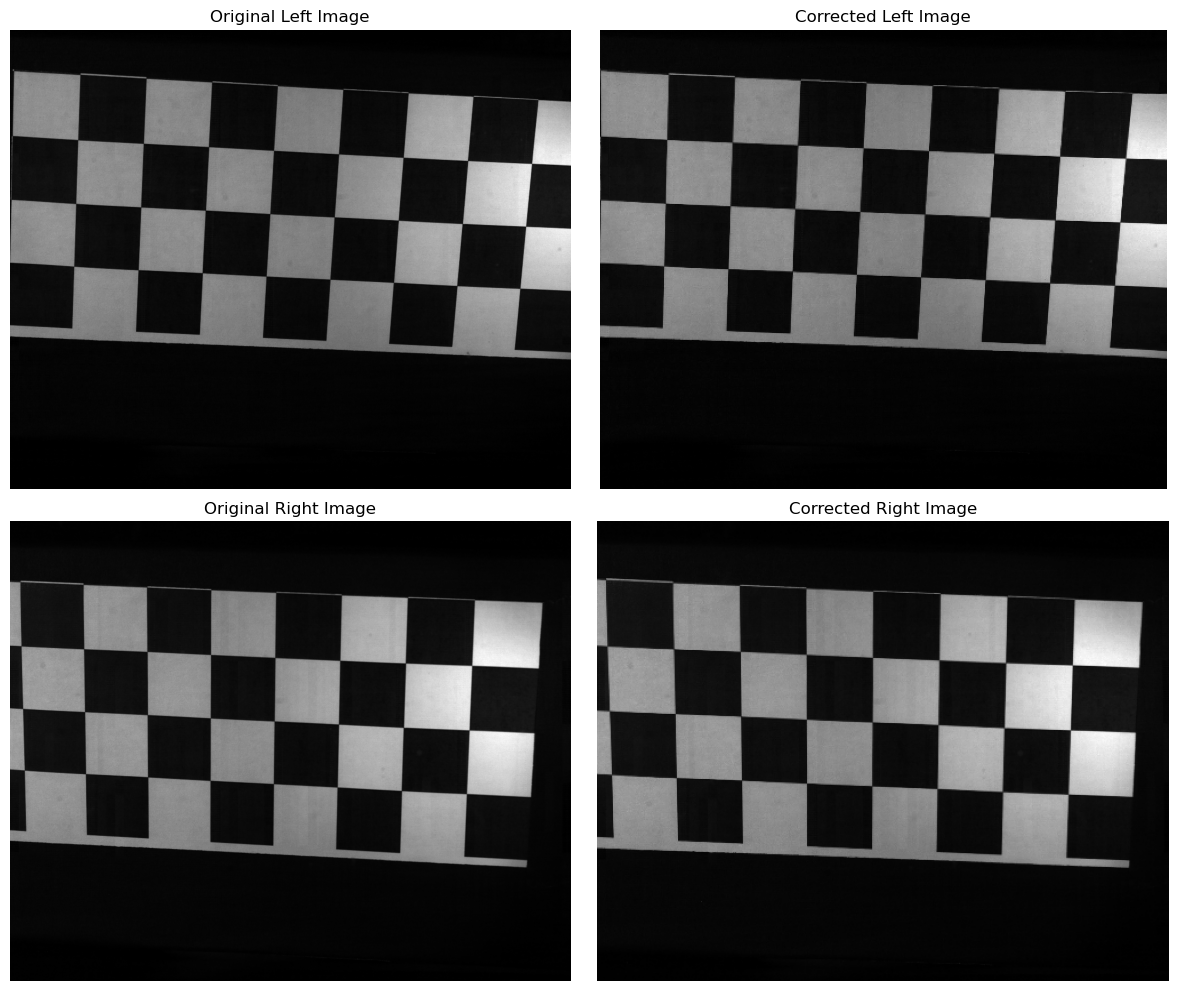

In [12]:
# Plot the images using Matplotlib
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Left Camera - Original vs. Corrected
axes[0, 0].imshow(img1, cmap='gray')
axes[0, 0].set_title("Original Left Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(undistorted_rectified_1, cmap='gray')
axes[0, 1].set_title("Corrected Left Image")
axes[0, 1].axis("off")

# Right Camera - Original vs. Corrected
axes[1, 0].imshow(img2, cmap='gray')
axes[1, 0].set_title("Original Right Image")
axes[1, 0].axis("off")

axes[1, 1].imshow(undistorted_rectified_2, cmap='gray')
axes[1, 1].set_title("Corrected Right Image")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


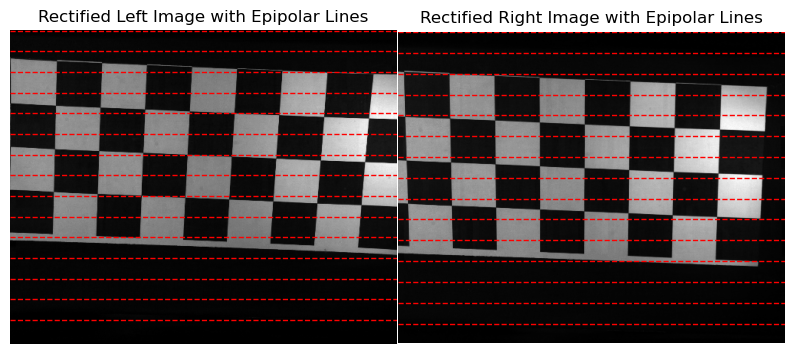

In [13]:
def draw_epipolar_lines(image1, image2):
    """ Draw horizontal epipolar lines to verify rectification """
    h, w = image1.shape[:2]
    num_lines = 15  # Number of lines to draw
    spacing = h // num_lines

    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    axes[0].imshow(image1, cmap='gray')
    axes[1].imshow(image2, cmap='gray')

    for i in range(num_lines):
        y = i * spacing
        axes[0].axhline(y, color='red', linestyle='--', linewidth=1)
        axes[1].axhline(y, color='red', linestyle='--', linewidth=1)

    axes[0].set_title("Rectified Left Image with Epipolar Lines")
    axes[1].set_title("Rectified Right Image with Epipolar Lines")
    axes[0].axis("off")
    axes[1].axis("off")
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.005)  # Reduce horizontal spacing (default is higher)
    plt.show()

# Apply function to the corrected images
draw_epipolar_lines(undistorted_rectified_1, undistorted_rectified_2)

In [14]:
img_1=undistorted_rectified_1
img_2=undistorted_rectified_2

sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [15]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [16]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

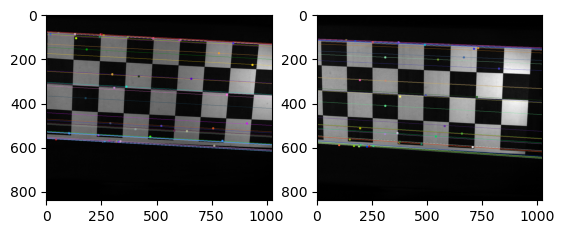

In [17]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()